# Response time minimization problem for East police district

### Version 3.2

- Goal: Minimize the response time of police vehicles in East police district, Norway.
- The problem is formulated as a capacitated vehicle positioning problem using PuLP.

Previous notebook worked through the pipeline for the East police district and introduced speed-upgrades for PuLP processing.  
This notebook contains improvements to the pipeline:
- Modify event simulation to be derived purely from population count, instead of adding randomness. This will make it more reproduceable and easier to compare results. 
- Problem size reduction: Filter out pairs with the top X% travel times, as there probably is another closer car to the event. Significant speed-up of processing. A 60% reduction resulted in the same answer and cut PuLP solving time from 30 sec to 3 sec.
- Plot of PuLP optimization process LP vs MILP
- More structured output results from PuLP variables
- Improved plotting of optimal locations and assigned events

In [1]:
# import watermark
%reload_ext watermark
%watermark

Last updated: 2024-03-30T23:56:19.346255+01:00

Python implementation: CPython
Python version       : 3.11.6
IPython version      : 8.22.2

Compiler    : MSC v.1935 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 12
Architecture: 64bit



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import shapely
from shapely.geometry import Point, LineString, Polygon, MultiPolygon, mapping
from shapely.ops import nearest_points, unary_union
from descartes import PolygonPatch
import pyproj
import geopandas as gpd
import osmnx as ox
import networkx as nx
import pandana as pdna
import pulp
import highspy
import folium
import utilityModule # own custom functions

pd.set_option('display.float_format', lambda x: '%.3f' % x)
ox.settings.log_console=True
ox.settings.use_cache=True
%watermark -w
%watermark -iv

Watermark: 2.4.3

matplotlib: 3.8.3
geopandas : 0.14.3
osmnx     : 1.9.1
pulp      : 2.8.0
folium    : 0.16.0
networkx  : 3.2.1
pyproj    : 3.6.1
numpy     : 1.26.4
highspy   : 1.5.3
shapely   : 2.0.3
pandas    : 2.2.1
pandana   : 0.7



## 0. Load road network

We load a road network of Øst police district that has been slightly preprocessed.
- Network type: drive
- Akershus and Østfold counties minus Asker, Bærum, Jevnaker and Lunner.
- CRS: WGS84 EPSG:4326, will be converted to UTM33N EPSG:32633
- Network already contains edge weights (travel time in seconds)
- Node closeness centrality has already been calculated for the network and stored as a CSV file.

In [3]:
### Load road network file of Øst police district, Norway
# Read from local path
ost_filepath = "../data/ost/OstDriveImputed.graphml" # with travel time attribute
ost_graph = ox.load_graphml(ost_filepath) # originally in WGS84 (EPSG:4326)

In [4]:
ost_graph = ox.projection.project_graph(ost_graph, to_crs='EPSG:32633') # if need to project to UTM zone 33N
print(f"Type of ost_graph: {type(ost_graph)}")
print(f"CRS of ost_graph:  {ost_graph.graph['crs']}")

# plot graph
# fig, ax = ox.plot_graph(ost_graph, node_size=1, edge_linewidth=0.2, edge_color="w", bgcolor="k")

Type of ost_graph: <class 'networkx.classes.multidigraph.MultiDiGraph'>
CRS of ost_graph:  EPSG:32633


Convert graph to GeoDataFrame and plot it.   
`osmnx.utils_graph.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)` - Convert a MultiDiGraph to node and/or edge GeoDataFrames.

In [5]:
# converting the graph network to node and edge GeoPandas GeoDataFrames
nodes, edges = ox.graph_to_gdfs(ost_graph, nodes=True, edges=True)
print(f"type of nodes:{type(nodes)}")
# nodes.head()
edges.head(2) # verify edges contain speed and travel time

type of nodes:<class 'geopandas.geodataframe.GeoDataFrame'>


osmid  \
u         v          key                                      
265629056 8595477415 0    [629271201, 120466454, 926242999]   
          8595512022 0               [926242773, 110781343]   

                                                 name       highway  oneway  \
u         v          key                                                      
265629056 8595477415 0    [Storesandveien, Vadholmen]  unclassified   False   
          8595512022 0                      Storveien       primary   False   

                         reversed   length  \
u         v          key                     
265629056 8595477415 0       True 1061.374   
          8595512022 0      False  435.557   

                                                                   geometry  \
u         v          key                                                      
265629056 8595477415 0    LINESTRING (271942.408 6550299.054, 271939.667...   
          8595512022 0    LINESTRING (271942.408 6550299.054, 271945.319...   

                          speed_kph  travel_time  ref  maxspeed bridge  \
u         v          key                                                 
265629056 8595477415 0       39.800       96.000  NaN       NaN    NaN   
          8595512022 0       50.000       31.400  108  [60, 40]    NaN   

                         junction lanes tunnel width access est_width  
u         v          key                                               
265629056 8595477415 0        NaN   NaN    NaN   NaN    NaN       NaN  
          8595512022 0        NaN   NaN    NaN   NaN    NaN       NaN

## 1. Simulate event points

Steps:  
1.1 Load preprocessed population data  
1.2 Event simulation based purely on population count. Should fall in range [2000,2500]  
1.3 Snap points to network (after defined Pandana network)  

### 1.1 Load preprocessed population data  

We load preprocessed population data of Øst police district in 250x250m grid cells.
- Correct extent: Akershus and Østfold counties minus Asker, Bærum, Jevnaker and Lunner.
- CRS: WGS84 EPSG:4326, will be converted to UTM33N EPSG:32633 before analysis.

In [6]:
# load preprocessed population data and convert to CRS UTM zone 33N (EPSG:32633)
ost_polygon_path = "../data/ost/OstCombinedPolygon.geojson"
population_path = "../data/ost/OstPopulation.geojson"
ost_polygon_gdf = gpd.read_file(ost_polygon_path)
population_gdf = gpd.read_file(population_path)
ost_polygon_gdf = ost_polygon_gdf.to_crs(ost_graph.graph['crs']) # convert to same CRS as the road network
population_gdf = population_gdf.to_crs(ost_graph.graph['crs']) # convert to same CRS as the road network
print(f"type of pop_df: {type(population_gdf)}")
print(f"columns of population_gdf: {population_gdf.columns}")
population_gdf.head(2)

type of pop_df: <class 'geopandas.geodataframe.GeoDataFrame'>
columns of population_gdf: Index(['id', 'population', 'geometry'], dtype='object')


,id,population,geometry
0,22735006545750,4,"POLYGON ((273500.000 6545750.000, 273500.000 6..."
1,22737506546000,2,"POLYGON ((273750.000 6546000.000, 273750.000 6..."


In [7]:
# # plot the clipped population data, with the polygon as outline and the population colored by population size
# fig, ax = plt.subplots(figsize=(6,6))
# vmin, vmax = 0, 200
# ost_polygon_gdf.boundary.plot(ax=ax, color='black', linewidth=0.5, alpha=0.7)
# population_gdf.plot(ax=ax, column='population', cmap='Reds', legend=True, alpha=0.7, vmin=vmin, vmax=vmax)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# plt.title('Øst police district: Population data')
# plt.tight_layout(); plt.show()

### 1.2 Event simulation based on population counts

For each gridcell, simulated events are generated based on the population count and scaled with a self-adjustable factor that ensure the total number of simulated events will fall in the preferred range of [2000,2500].

In [8]:
# calculate the number of points to simulate in each grid cell - vectorized version
population_gdf = utilityModule.simulate_event_points(population_gdf, min_range=1000, max_range=1500)

# print the number of cells with 0, 1, 2, ..., 9 events
for i in range(0, 6):
    print(f"Nr of cells with {i} events: {len(population_gdf[population_gdf['num_points'] == i])}")

# print the cells with the highest number of points
population_gdf.nlargest(3, 'num_points')

Total number of simulated event points: 1016. Target range [1000, 1500], using population multiplier: 0.0026875
Nr of cells with 0 events: 24081
Nr of cells with 1 events: 957
Nr of cells with 2 events: 24
Nr of cells with 3 events: 2
Nr of cells with 4 events: 0
Nr of cells with 5 events: 1


,id,population,geometry,num_points
17847,22735006649250,1697,"POLYGON ((273500.000 6649250.000, 273500.000 6...",5
6398,22740006649000,1147,"POLYGON ((274000.000 6649000.000, 274000.000 6...",3
17843,22737506649000,1186,"POLYGON ((273750.000 6649000.000, 273750.000 6...",3


In [9]:
%%time
# List to hold all generated points
event_points = []
# Iterate over rows in your GeoDataFrame
for _, row in population_gdf.iterrows():
    # Extract number of points to generate for the current row
    num_points = row['num_points']
    if num_points > 0:  # Proceed only if there are points to generate
        # Generate points within the grid cell 
        points = utilityModule.generate_points_within_gridcell(num_points, row['geometry'].bounds)
        event_points.extend(points)

# Create a GeoDataFrame from the generated points
event_points_gdf = gpd.GeoDataFrame(geometry=event_points, crs=population_gdf.crs)
event_points_gdf.head(3)

CPU times: total: 812 ms
Wall time: 1.26 s


,geometry
0,POINT (271343.729 6570213.602)
1,POINT (270903.386 6570512.284)
2,POINT (267967.144 6565115.792)


Total number of simulated event points: 1016


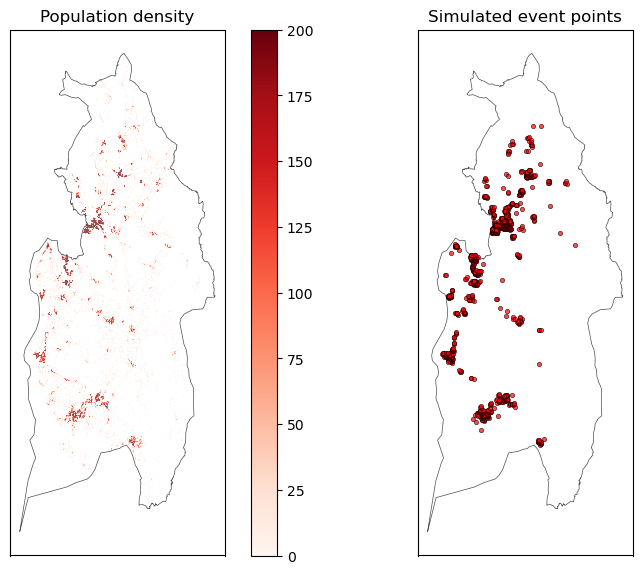

In [10]:
# 2 subplots side-by-side of population density and simulated event points
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
vmin, vmax = 0, 200
ost_polygon_gdf.boundary.plot(ax=ax1, color='black', linewidth=0.5, alpha=0.7)
population_gdf.plot(ax=ax1, column='population', cmap='Reds', legend=True, alpha=0.7, vmin=vmin, vmax=vmax)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_title('Population density')

ost_polygon_gdf.boundary.plot(ax=ax2, color='black', linewidth=0.5, alpha=0.7)
event_points_gdf.plot(ax=ax2, color='red', markersize=10, alpha=0.7, edgecolor='black', lw=0.5)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_title('Simulated event points')
print(f"Total number of simulated event points: {len(event_points_gdf)}")
plt.tight_layout(); plt.show()

In [11]:
high_pop_density_area = utilityModule.generate_high_density_polygon(event_points_gdf, grid_size=100, density_threshold=1.4e-10, simplification_tolerance=5.0, plot_results=False)

Density: Min: 8.374e-19 | Median: 4.280e-11 | Mean: 1.222e-10 | Max: 1.173e-09


Total number of simulated event points: 1016


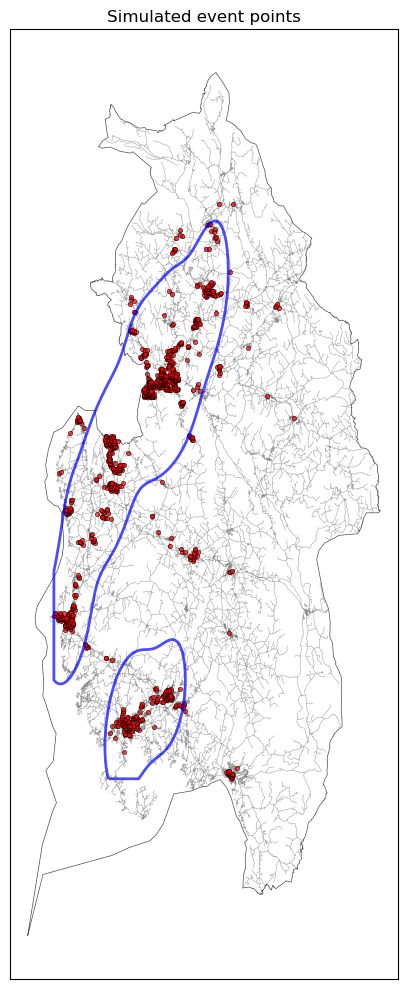

In [12]:
# plot road network and final polygon
fig, ax = plt.subplots(figsize=(10, 10))
edges.plot(ax=ax, linewidth=0.3, color='gray', alpha=0.5, zorder=-1)
ost_polygon_gdf.boundary.plot(ax=ax, color='black', linewidth=0.5, alpha=0.7)
high_pop_density_area.boundary.plot(ax=ax, color='blue', linewidth=2, alpha=0.7)
event_points_gdf.plot(ax=ax, color='red', markersize=10, alpha=0.7, edgecolor='black', lw=0.5)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('Simulated event points')
print(f"Total number of simulated event points: {len(event_points_gdf)}")
plt.tight_layout(); plt.show()

## 2. Police car candidate points

Steps:  
2.1 Add Centrality measure as node attribute  
2.2 Sample candidate points and filter out poor candidate points

### 2.1 Add Centrality measure as node attribute

Next we load the pre-computed closeness centrality and add it as an attribute to the nodes GeoDataFrame.  

*Closeness centrality is a measure of how close a node is to all other nodes in the network.   
It is calculated as the reciprocal of the sum of the shortest path distances from the node to all other nodes in the graph.*

In [13]:
# import node closeness centrality from file
# if closeness centrality is in the nodes GeoDataFrame, drop it
if 'closeness_centrality' in nodes.columns:
    nodes.drop(columns=['closeness_centrality'], inplace=True)

nodes_centrality_import = pd.read_csv("../data/ost/OstNodeCentrality.csv")

# Now use the merge function. Since 'osmid' is the index in `nodes`, we can merge on the index
nodes = nodes.merge(nodes_centrality_import, left_index=True, right_on='osmid')

# After the merge, if you want 'osmid' as a column instead of an index, you can reset the index
nodes.reset_index(drop=True, inplace=True)
nodes.set_index('osmid', inplace=True)
nodes.head(2)

,y,x,street_count,lon,lat,highway,ref,geometry,closeness_centrality
osmid,,,,,,,,,
265629056,6550299.054,271942.408,3,11.025,59.031,NaN,NaN,POINT (271942.408 6550299.054),0.000
8595477415,6549913.134,271187.495,1,11.013,59.027,NaN,NaN,POINT (271187.495 6549913.134),0.000


Now, that the closeness centrality is added as an attribute to the ``nodes`` GeoDataFrame, we can use this to filter out better candidate locations for the police cars.

### 2.2 Sample candidate points and filter out poor candidate points

#### Steps:
1. Sample a set of random points from the road network (using the high population density areas as a polygon).
2. Filter out points that are too close to the border of the road network (closeness centrality threshold).
3. Filter out points that are too close to each other.
4. Filter out points that are too close to the existing police stations.

In [14]:
# random nodes from the graph
SEED = 2
NR_OF_CAR_NODES = 50

# sample X random source nodes from the area high_pop_density_area
car_nodes = nodes[nodes.within(high_pop_density_area.geometry.values[0])]
car_nodes = car_nodes.sample(NR_OF_CAR_NODES, random_state=SEED) # sample X random source nodes
print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# car_nodes = nodes.sample(NR_OF_CAR_NODES, random_state=SEED) # sample X random source nodes
# print(f"Total nr of nodes: {len(nodes)}, nr of police car nodes: {len(car_nodes)}")

# make car_nodes into a GeoDataFrame
car_nodes_gdf = gpd.GeoDataFrame(car_nodes, geometry=gpd.points_from_xy(car_nodes.x, car_nodes.y))
car_nodes.head(2)

Total nr of nodes: 47948, nr of police car nodes: 50


,y,x,street_count,lon,lat,highway,ref,geometry,closeness_centrality
osmid,,,,,,,,,
6478270849,6664681.533,284224.905,3,11.123,60.062,NaN,NaN,POINT (284224.905 6664681.533),0.000
6601344152,6575163.233,281239.054,1,11.162,59.259,NaN,NaN,POINT (281239.054 6575163.233),0.000


Input nr of car nodes: 50
Remaining nr of car nodes: 40, after discarding the 10 (20%) remote car nodes with lowest closeness centrality



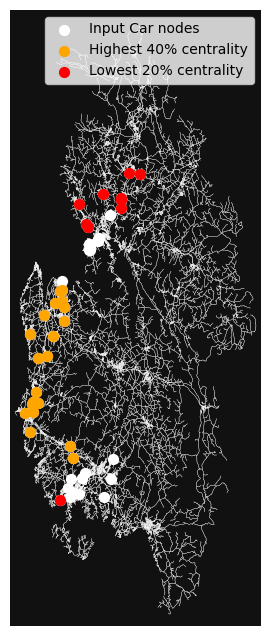

In [15]:
car_nodes_gdf_central = utilityModule.filter_and_plot_nodes_by_centrality(geo_df=car_nodes_gdf, top_percent=0.4, bottom_percent=0.20, input_graph=ost_graph, plot=True)

Input nr of car nodes: 40
Remaining nr of car nodes: 26, after removing the 14 nodes that are within 2500 m of each other



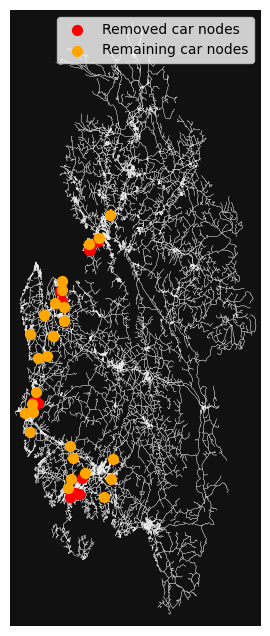

In [16]:
car_nodes_gdf_filtered = utilityModule.filter_nodes_by_proximity(geo_df=car_nodes_gdf_central, min_distance=2500, input_graph=ost_graph, criterion_col='closeness_centrality', prefer='higher', plot=True)

## 3. Define the Pandana network

Now we use the GeoDataFrames from `osmnx` to create a `pandana` network.

Pandana networks is defined like this:   
`pandana.network.Network(node_x, node_y, edge_from, edge_to, edge_weights, twoway=True)`  

 **edge_weights**: DataFrame, all numerics   
- Specifies one or more impedances on the network which define the distances between nodes.  
- Multiple impedances can be used to capture travel times at different times of day, for instance.

We will use both ``length`` and ``travel_time`` as edge weights. However, we must specify which one to use when querying the network (cannot calculate with both at the same time).

In [17]:
# reset index so our origins and destinations are not in index
edges = edges.reset_index()
# nodes = nodes.reset_index()

# create network with pandana
ost_network_pdna = pdna.Network(node_x=nodes['x'], node_y=nodes['y'], edge_from=edges['u'], edge_to=edges['v'], 
                                      edge_weights=edges[["length", "travel_time"]], twoway=True)

# Print stats about the network
print(f"type of ost_network_pdna: {type(ost_network_pdna)}")
print(f"Network nodes:")
ost_network_pdna.nodes_df.head(2)

type of ost_network_pdna: <class 'pandana.network.Network'>
Network nodes:


,x,y
osmid,,
265629056,271942.408,6550299.054
8595477415,271187.495,6549913.134


In [18]:
print(f"Network edges: ")
ost_network_pdna.edges_df.head(2)

Network edges: 


,from,to,length,travel_time
0,265629056,8595477415,1061.374,96.000
1,265629056,8595512022,435.557,31.400


In [19]:
# %%time
# ost_network_pdna.precompute(3000)

Recall that the Car Nodes were directly sampled from the road network, while event points were generated outside the road network.   
Therefore, we need to snap the event points to the Pandana network.

In [20]:
# identify nearest node to each event point
event_points_gdf['nearest_node'] = ost_network_pdna.get_node_ids(event_points_gdf.geometry.x, event_points_gdf.geometry.y, mapping_distance=1000)

# With nearest_node attribute, find osm x,y coordinates
event_points_gdf = event_points_gdf.merge(nodes[['x', 'y']], left_on='nearest_node', right_index=True, suffixes=('', '_nearest_node'))
event_points_gdf.head(2)

,geometry,nearest_node,x,y
0,POINT (271343.729 6570213.602),1105751031.000,271334.735,6570195.461
1,POINT (270903.386 6570512.284),446363221.000,270946.189,6570586.570


In [21]:
# Get list of nearest node ids for event locations
event_nodes_pdna = ost_network_pdna.get_node_ids(x_col=event_points_gdf.geometry.x, y_col=event_points_gdf.geometry.y).values
event_nodes_pdna[:5]

# get the nearest node ids (in this case, just selecting the 'osmid')
car_nodes_pdna = ost_network_pdna.get_node_ids(x_col=car_nodes_gdf_filtered.x, y_col=car_nodes_gdf_filtered.y).values
car_nodes_pdna[:5]

array([8121475521,  247925255, 8121476615,     159376, 1432149062],
      dtype=int64)

In [22]:
# # converting the event nodes to a geodataframe
# event_nodes_snap_gdf = gpd.GeoDataFrame(geometry=[Point(ost_network_pdna.nodes_df.loc[node, 'x'], ost_network_pdna.nodes_df.loc[node, 'y']) for node in event_points_gdf], crs="EPSG:32633")
# event_nodes_snap_gdf.head(2)

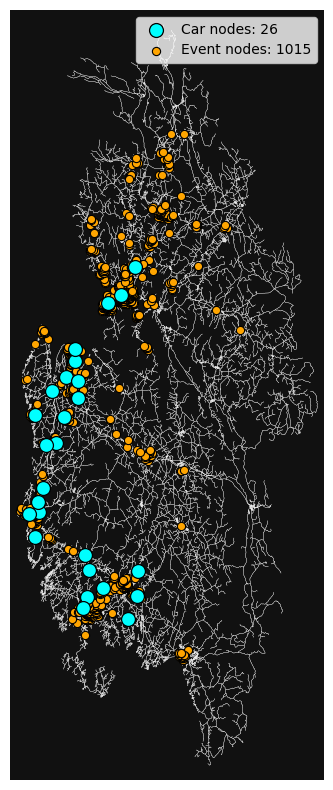

In [23]:
# Plot nodes for overview using ox.plot
fig, ax = ox.plot_graph(ost_graph, node_color="white", node_size=0, edge_linewidth=0.2, edge_color="w", show=False, close=False, figsize=(10,10))
# add number of events and car nodes to the legend
ax.scatter(car_nodes_gdf_filtered['x'], car_nodes_gdf_filtered['y'], c='cyan', edgecolor='black', lw=0.90, s=100, label=f"Car nodes: {len(car_nodes_gdf_filtered)}", zorder=3)
ax.scatter(event_points_gdf['x'], event_points_gdf['y'], c='orange', s=35, edgecolor='black', lw=0.80, label=f"Event nodes: {len(event_points_gdf)}", zorder=2)
ax.legend(); plt.show()

## 4. Cost Matrix - Calculate all origin-destination pairs

First, identify the nearest node to each Police car and Event.
- [network.get_node_ids()](http://udst.github.io/pandana/network.html#pandana.network.Network.get_node_ids)

In [24]:
# Creating origins-destination pairs
origins = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
destinations = np.tile(event_nodes_pdna, len(car_nodes_pdna))

In [25]:
%%time
# distance between each possible pair of facilities-clients combination
distances = ost_network_pdna.shortest_path_lengths(origins, destinations, imp_name='length')
travel_times = ost_network_pdna.shortest_path_lengths(origins, destinations, imp_name='travel_time')

print(type(distances))
print("Number of distances calculated: ", len(distances), "\n")
print("5 first origin-destination distances [m]     :", distances[:5])
print("5 first origin-destination travel times [sec]:", travel_times[:5], "\n")

<class 'list'>
Number of distances calculated:  26390 

5 first origin-destination distances [m]     : [56652.328, 56041.746, 59714.369, 55852.228, 56220.121]
5 first origin-destination travel times [sec]: [2390.2, 2463.2, 2693.7, 2487.9, 2495.5] 

CPU times: total: 1.83 s
Wall time: 194 ms


In [26]:
# print the statistics for distances and travel times
# print("Distances statistics:")
# print(pd.Series(distances).describe())
print("\nTravel times statistics:")
print(pd.Series(travel_times).describe())


Travel times statistics:
count   26390.000
mean     3100.043
std      1785.835
min         6.900
25%      1482.700
50%      3218.750
75%      4550.174
max      7503.000
dtype: float64


In [27]:
# Restructure the distances and travel times arrays into a DataFrame (Cost Matrix) and add the car and event node ids as columns

# create a DataFrame from the distances and travel times arrays
CostMatrix = pd.DataFrame({'distance': distances, 'travel_time': travel_times})

# add the car and event node ids as columns
CostMatrix['carNodeID'] = np.repeat(car_nodes_pdna, len(event_nodes_pdna))
CostMatrix['eventNodeID'] = np.tile(event_nodes_pdna, len(car_nodes_pdna))
CostMatrix.head() # distances, travel times, car and event node ids

# merge the distances DataFrame with the car and event nodes DataFrames to get the coordinates
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='carNodeID', right_index=True, suffixes=('', '_car'))
CostMatrix_extended = CostMatrix.merge(nodes[['x', 'y']], left_on='eventNodeID', right_index=True, suffixes=('', '_event'))
CostMatrix.head(2)

,distance,travel_time,carNodeID,eventNodeID
0,56652.328,2390.200,8121475521,1105751031
1,56041.746,2463.200,8121475521,446363221


In [28]:
CostMatrix_extended.head(2) # distances, travel times, car and event node coordinates

,distance,travel_time,carNodeID,eventNodeID,x,y
0,56652.328,2390.200,8121475521,1105751031,271334.735,6570195.461
1,56041.746,2463.200,8121475521,446363221,270946.189,6570586.570


In [29]:
# Save cost matrix to CSV
CostMatrix.to_csv("../data/ost/OstCostMatrix.csv", index=False)

# # import cost matrix from CSV
# CostMatrix_imported = pd.read_csv("../data/ost/OstCostMatrix.csv")
# CostMatrix_imported.head(2)

CostMatrix.drop(columns="distance", inplace=True)

Now, we have made Cost Matrices with distances and travel times between each police car and event node pair.
- ``CostMatrix`` is the lean cost matrix that will be used for further computations in optimization problems. - *saved as local .csv file for later use*
- ``CostMatrix_extended`` is the cost matrix extended with coordinate information. Useful for post-optimization tasks.

# 5. Optimization problem

### 5.1 Formulating the problem
We will use the Python library PuLP to model and solve the optimization problem.   
The objective is to minimize the total response time to events, by optimally positioning a fixed number of police cars.

### Notation

Let's define the notation that will be used to formulate the problem:
- $N$ : The set of all nodes in the road network.
- $E$ : The set of events, each associated with a node in $N$ and a severity score.
- $P$ : The set of potential police car locations, a subset of $N$.
- $C_{ij}$ : The travel time from police car location $i \in P$ to event location $j \in E$.
- $x_i$ : Binary decision variable where $x_i = 1$ if a police car is positioned at node $i$, and $x_i = 0$ otherwise.
- $y_{ij}$ : Binary decision variable where $y_{ij} = 1$ if the event $j$ is assigned to the police car located at $i$, and $y_{ij} = 0$ otherwise.

### Objective Function
The objective is to minimize the total response time to all events. The response time is the travel time from a police car to an event, considering only the assignments where $y_{ij} = 1$.
$$
\text{Minimize} \quad Z = \sum_{i \in P} C_{ij} \cdot y_{ij}
$$

### Constraints
1. **Police Car Placement Constraint**: Only $K$ police cars are available to be deployed.
$$
\sum_{i \in P} x_i = K
$$

2. **Event Assignment Constraint**: Each event must be assigned to exactly one police car.
$$
\sum_{i \in P} y_{ij} = 1 \quad \forall j \in E
$$

3. **Validity Constraint**: An event can only be assigned to a police car if that car is positioned at a node.
$$
y_{ij} \leq x_i \quad \forall i \in P, \forall j \in E
$$

4. **Capacity Constraint**: Each police car can only be assigned to a limited number of events.
$$
\sum_{j \in E} y_{ij} \leq M_i \cdot x_i \quad \forall i \in P
$$

5. **Non-Negativity and Integrality**: Ensure that the decision variables are binary.
$$
x_i \in \{0, 1\} \quad \forall i \in P
$$
$$
y_{ij} \in \{0, 1\} \quad \forall i \in P, \forall j \in E
$$


### 5.2 Preprocessing data structures for efficient computation

In [30]:
# Preprocess the cost matrix
# 1) Convert to a dictionary for fast lookup
# 2) Reduce problem size: Remove top x% travel times, as there is probably a closer car to the event

DISCARD_THRESHOLD = 0.50
CostMatrix_dict_reduced = utilityModule.preprocess_cost_matrix(CostMatrix, discard_threshold=DISCARD_THRESHOLD, verbose=True)

Filtering out 50% highest travel times - keeping only travel times <= 3194 sec, or 53.2 min
Original nr of pairs: 25610 | Filtered nr of pairs: 12805
Original max travel time: 7503.0 | Filtered max travel time: 3193.9
Original min travel time: 6.9 | Filtered min travel time: 6.9


### 5.2 Setup LP problem

In [31]:
# Constants
NR_OF_CARS = 4
CAR_CAPACITY = 260

# # Sets
P = CostMatrix['carNodeID'].unique()  # Potential police car locations
E = CostMatrix['eventNodeID'].unique()  # Events

# Define PuLP problem
problem = utilityModule.define_pulp_problem(CostMatrix, CostMatrix_dict_reduced, nr_of_cars=NR_OF_CARS, car_capacity=CAR_CAPACITY, problem_name="PoliceCarLocationOptimization", verbose=True)

Number of police car locations: 26
Number of events: 985
Number of decision variables: 12831
Number of constraints: 13817
Number of non-zero coefficients: 12831
Number of non-zero coefficients in the objective function: 12805
Problem setup took 0.57 seconds


### 5.5 Run the solvers

- **PULP_CBC (COIN-OR Branch and Cut)** - default solver in PuLP. It is an open-source solver that is included in the PuLP package. It is a branch-and-cut solver that uses the COIN-OR CBC optimization engine.

- **HiGHS (High-Performance Solver)** - a high-performance solver that use the HiGHS optimization engine. It has been designed to solve large-scale linear programming problems and is particularly well-suited for solving problems with a large number of constraints and variables. Can use multiple threads to significantly speed up the solution process for complex problems. 


#### Solver configuration:
**``mip=True``** - signals solver to use algorithms and heuristics designed for integer constraints, ensuring that the solution adheres to the binary variable requirements. However, ``mip=False`` can relax the integer constraints and simplify the solution space for optimization algorithms to navigate. Can sometimes be faster, but result needs to be inspected, as they might be invalid.  
Note: relaxing integer constraints can drastically reduce complexity and, consequently, the solving time. This is expected behavior as integer programming problems are generally NP-hard, while their linear programming counterparts (with relaxed integer constraints) can be solved in polynomial time.

1st run of each solver will relax the integer variable constraint (`mip=False`) for fast computation. 2nd run of each solver will use proper integer constraints (`mip=True`) to get the slow, final solution for verification.

*Recall this is a minimization problem, so the lower the objective value, the better the solution.*

In [32]:
# Inspect available pulp solvers
pulp.listSolvers(onlyAvailable=True)

['GLPK_CMD', 'PULP_CBC_CMD', 'COIN_CMD', 'HiGHS']

In [33]:
# Run the solver
optimal_police_locations = utilityModule.run_solvers(problem, P, nr_of_locations=4, solver_name='PULP_CBC_CMD', forceMIP=True, plot=False)
print(f"(Note: Currently reducing the Cost matrix by {DISCARD_THRESHOLD*100}%)")

PULP_CBC_CMD with LP relaxation found 3/4 locations in 2.23 seconds.
Switching to MILP solver configuration to find optimal solution.

Optimal police car locations found: 4/4 in 10.69 seconds: [    159376  305324661 2012771318  299167717]
Solver: PULP_CBC_CMD | Status: 1 (Optimal)
Objective function value (total response time): 633947.3910 seconds, or 10565.79 minutes, or 176.10 hours
(Note: Currently reducing the Cost matrix by 50.0%)


In [34]:
# extract the objective value
objective_value = pulp.value(problem.objective)
print(f"Objective value: {objective_value}")

Objective value: 633947.391


### 5.6 Extract results for inspection

In [35]:
# Extracting optimal police car locations
# optimal_police_locations = [i for i in P if x[i].varValue == 1]
optimal_police_locations_gdf = gpd.GeoDataFrame(geometry=[Point(ost_network_pdna.nodes_df.loc[node, 'x'], ost_network_pdna.nodes_df.loc[node, 'y']) for node in optimal_police_locations], crs="EPSG:32633")

# export optimal_police_car_locations_gdf to CSV
optimal_police_locations_gdf.to_csv('../data/ost/OstOptimalLocations.csv', index=False)

results = []
# Iterate directly over the variables in the problem
# Avoid creating keys which is computationally expensive
for var in problem.variables():
    # Check if the variable is a 'y' variable and its value is 1
    if var.name.startswith("y_") and var.varValue == 1:
        # Extract the indices 'i' and 'j' from the variable name
        # This assumes the name format is "y_(i,j)"
        indices = var.name[2:].strip("()").split(',_')
        i = indices[0]  # Convert to int if necessary
        j = indices[1]  # Convert to int if necessary
        
        # Append to results if the variable is part of the solution
        results.append({'carNodeID': i, 'eventNodeID': j})

# Creating a DataFrame from the results
results_df = pd.DataFrame(results)

# Ensure carNodeID and eventNodeID have same data types in both DataFrames
# normal int not large enough, switched to pandas Int64 that handle large values, NaN, etc
results_df['carNodeID'] = results_df['carNodeID'].astype('Int64')
results_df['eventNodeID'] = results_df['eventNodeID'].astype('Int64')
CostMatrix_extended['carNodeID'] = CostMatrix_extended['carNodeID'].astype('Int64')
CostMatrix_extended['eventNodeID'] = CostMatrix_extended['eventNodeID'].astype('Int64')

# Merging with CostMatrix_extended to add distance, travel_time, and coordinates
results_df = pd.merge(results_df, CostMatrix_extended[['carNodeID', 'eventNodeID', 'distance', 'travel_time', 'x', 'y']], on=['carNodeID', 'eventNodeID'], how='left')
results_df.head(3)

,carNodeID,eventNodeID,distance,travel_time,x,y
0,159376,1014243426,6352.494,407.900,266531.850,6630744.613
1,159376,1022930325,6365.301,414.800,267472.921,6631465.807
2,159376,10527198,9219.997,393.300,266835.473,6638062.988


## 6. Visualization

### 6.1 Plot the optimal police car locations and events

Input parameters:
- Possible police car locations: 26 | Optimal locations in solution: 4
- Events: 1015 | Max event capacity per police car: 260

Solution from Linear Programming (LP) model:
Goal: minimize objective function (total response time)
Objective function value: 633947 sec | 10565.8 min | 176.10 hours

Police car id: 159376 handles 241 events | Capacity: 92.69% | Total response time: 2790.23 min | Avg response time: 11.58 min
Police car id: 2012771318 handles 291 events | Capacity: 111.92% | Total response time: 1486.68 min | Avg response time: 5.11 min
Police car id: 299167717 handles 203 events | Capacity: 78.08% | Total response time: 2463.21 min | Avg response time: 12.13 min
Police car id: 305324661 handles 280 events | Capacity: 107.69% | Total response time: 4081.68 min | Avg response time: 14.58 min


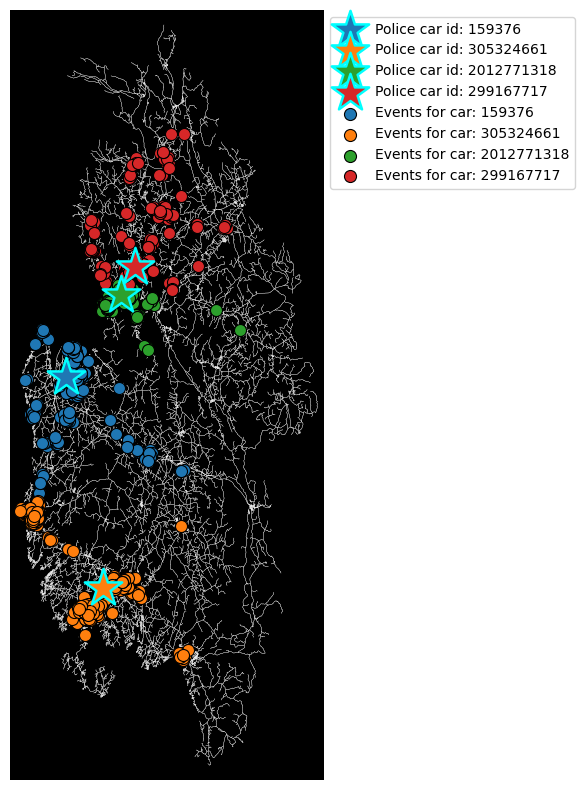

CPU times: total: 4.94 s
Wall time: 7.12 s


In [36]:
%%time
utilityModule.plot_optimal_allocations(ost_graph, optimal_police_locations_gdf, optimal_police_locations, 
                results_df, car_nodes_gdf_filtered, event_points_gdf, NR_OF_CARS, CAR_CAPACITY, problem)

## 6.2 Visualize Isochrones - How far can you drive in different time intervals?
How far can you drive in 1.5, 4 and 8 minutes from the origin nodes? We'll use NetworkX to induce a subgraph of gruner_graph within each distance, based on travel time.  
We also, plot isochrones as buffers to get more faithful isochrones than convex hulls can offer.

In [37]:
# Define how many trip times to visualize
TRIP_TIMES = [15, 30, 45]  # in minutes
ISO_COLORS = ['blue', 'magenta', 'yellow']  # Long, Middle, Short ranges

In [38]:
# %%time
# # Generate isochrone polygons
# isochrone_polys = utilityModule.make_iso_polys(ost_graph, TRIP_TIMES, optimal_police_locations, 
#                                                 edge_buff=30, node_buff=0, infill=True)

# # Merge isochrones
# merged_isochrones = utilityModule.merge_isochrones(ost_graph, isochrone_polys)

# # Plotting the graph and merged isochrones
# fig, ax = ox.plot_graph(ost_graph, show=False, close=False, edge_color='#999999', edge_alpha=0.2, node_size=0, bgcolor='k', figsize=(15, 15))

# # Plotting merged isochrones with colors
# # iso_colors = ['blue', 'magenta', 'yellow']  # Long, Middle, Short ranges
# for merged_poly, color in zip([merged_isochrones[0], merged_isochrones[1], merged_isochrones[2]], ISO_COLORS):
#     if isinstance(merged_poly, MultiPolygon):
#         for poly in merged_poly.geoms:
#             patch = PolygonPatch(poly, fc=color, ec='none', alpha=0.5, zorder=-1)
#             ax.add_patch(patch)
#     else:
#         patch = PolygonPatch(merged_poly, fc=color, ec='none', alpha=0.5, zorder=-1)
#         ax.add_patch(patch)

# print("Isochrone polygons for the travel times:", TRIP_TIMES, "minutes")
# plt.show()

In [39]:
# %%time
# # Plot leaflet map
# graph_map = utilityModule.plot_leaflet_map(ost_graph, TRIP_TIMES, merged_isochrones, ost_polygon_gdf, background_poly=True)
# graph_map